# Ejercicio 3

## Datos

**Wine Quality** del fichero **datos.xlsx**

**Y**= Densidad

**Eliminar:**

- PH
- Sulfatos
- Cloruros
- Acidez Volátil
- Acidez Fija
- Calidad del Vino

## Puntos

1. Estandarizar variables y calcular matrices de correlación de **Pearson**, **Kendall** y **Spearman**. ¿Qué diferencia hay entre las dependencias obtenidas?
2. Realizar particios de datos 80-20.
  - Construir 3 modelos RLM.
  - Comparar e interpretar los valores de los coeficientes de regresión en cada método.
3. ¿Cuál de los modelos propuestos predice mejor?
  - Realizar una predicción con los datos de prueba.
  - Calcular el RMSE.
4. Validar supuesto teóricos de cada modelo.
5. Realizar un diagrama de dispersión del conjunto de datos.
  - ¿Se evidencia comportamientos lineales?
  - Si no son lineales realizar transformaciones de varaibles y justificar.
  - Generar un modelo RLM e interpretar.

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, anderson
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel

In [123]:
url = 'https://github.com/cam2149/MachinelearningI/raw/85795f6469ebde1f693b7cb6c893c10135408974/datos.xls'

df_wine = pd.read_excel(url, sheet_name='Wine Quality',header=2)
df_wine.drop(columns=['pH', 'Sulfatos', 'Cloruros', 'Acidez Volátil', 'Acidez Fija', 'Calidad del Vino'], inplace=True)

df_wine = df_wine[['Densidad'] + [col for col in df_wine.columns if col != 'Densidad']]
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Densidad                 4898 non-null   float64
 1   Ácido Cítrico            4898 non-null   float64
 2   Azúcar Residual          4898 non-null   float64
 3   Dióxido de Azúfre Libre  4898 non-null   float64
 4   Dióxido de Azúfre Total  4898 non-null   float64
 5   Alcohol                  4898 non-null   float64
dtypes: float64(6)
memory usage: 229.7 KB


In [124]:
# standarize variables
scaler = StandardScaler()
df_wine_scaled = pd.DataFrame(scaler.fit_transform(df_wine),columns=df_wine.columns)
df_wine_scaled.describe()

,Densidad,Ácido Cítrico,Azúcar Residual,Dióxido de Azúfre Libre,Dióxido de Azúfre Total,Alcohol
count,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03
mean,-2.205033e-14,5.802717e-17,-1.066249e-16,-1.015476e-17,-4.642174e-17,-3.713739e-16
std,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00
min,-2.313038e+00,-2.761743e+00,-1.141944e+00,-1.958677e+00,-3.044230e+00,-2.043297e+00
25%,-7.707066e-01,-5.304757e-01,-9.250474e-01,-7.237750e-01,-7.144739e-01,-8.242757e-01
50%,-9.609320e-02,-1.172780e-01,-2.349217e-01,-7.692173e-02,-1.026189e-01,-9.286267e-02
75%,6.930457e-01,4.611988e-01,6.918185e-01,6.287364e-01,6.739664e-01,7.198184e-01
max,1.503130e+01,1.095642e+01,1.171411e+01,1.491831e+01,7.098444e+00,2.995326e+00


## Matrices de correlación

In [125]:
# Pearson correlation matrix
pearson_corr = df_wine_scaled.corr(method='pearson')

# Kendall correlation matrix
kendall_corr = df_wine_scaled.corr(method='kendall')

# Spearman correlation matrix
spearman_corr = df_wine_scaled.corr(method='spearman')


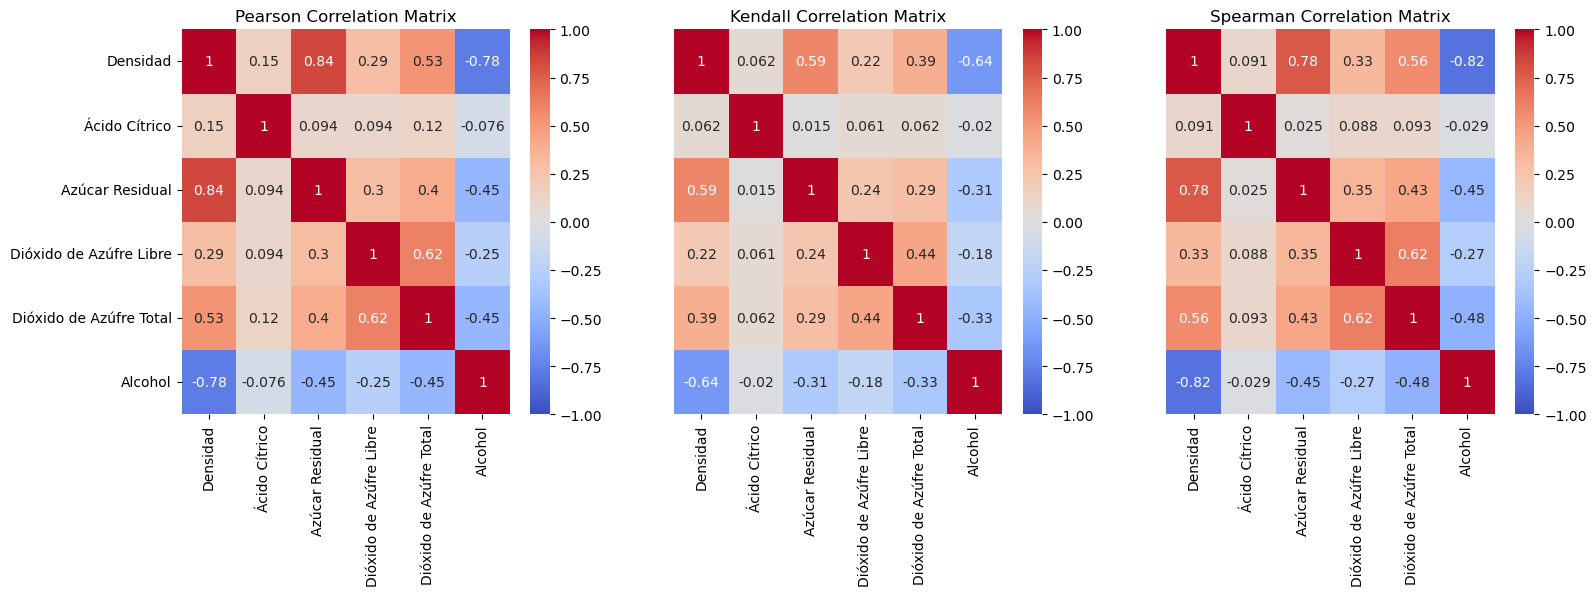

In [126]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))
ax[0].set_title('Pearson Correlation Matrix')
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,ax=ax[0])

ax[1].set_title('Kendall Correlation Matrix')
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1], yticklabels=False)

ax[2].set_title('Spearman Correlation Matrix')
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax[2], yticklabels=False)

plt.show()

## ¿Qué diferencia encuentra entre las estructuras de dependencias obtenidas?
Se procede a analizar la fuerza de relación entre variables. Se sigue la teoría de que para los modelos de **Pearson** y **Spearman** se considera una correlación fuerte para valores absolutos por encima de 0.7, mientras que para **Kendall** se considerará una correlación fuerte para valores absolutos por encima de 0.5.

### Relaciones Proporcionales Positivas
Es posible observar una relación positiva fuerte entre el Azúcar Residual con la Densidad en las 3 matrices. No se evidencia ningún otro par de variables que presente una relación de proporcionalidad positiva fuerte.

### Relaciones Inversamente Proporcionales
Se observa una relación inversa entre el Alcohol y todas las demás variables. Esta es la única variable que presenta alguna proporiconalidad negativa con las demás variables en las 3 matrices.

### Variables sin relación fuerte
Las variables de Dióxido de Azufre Libre, y Dióxido de Azufre Total presentan una relación proporcionalmente positiva de poca fuerza con la Densidad.

Se observa que el Ácido Cítrico y el Dióxido de Azufre libre no presentan relaciones lineales fuertes con ninguna de las demás variables.


Entre las 3 matrices, **Kendall** es donde la relación entre las variables tiene un valor absoluto más bajo debido a que el modelo mide la asociación ordinal entre las variables. Las matrices de **Pearson** y **Spearman** presentan valores similares. Para las variables de ácido cítrico y azúcar residual, **Pearson** tienen más fuerza. Mientras que, las otras 3 variables tienen mayor fuerza en **Spearman**. Adicionalmente, en **Pearson** el ácido cítrico tiene mayor fuerza que el alcohol, para **Kendall** y **Spearman** es alcohol el que presenta una mayor fuerza.

El orden de fuerza de las variables con respecto a la densidad en las 3 matrices es:

1.   Azúcar residual (Pearson) o alcohol
2.   Alcohol (Pearson) o azúcar residual
3.   Dióxido de azúfre total
4.   Dióxido de azúfre libre
5.   Ácido cítrico

## Modelos RLM

$\hat{β} = \hat{𝑃}^{-1}_{XX}\hat{𝑃}_{XY}$

$\hat{β}_0 = \hat{𝜇}_Y - \hat{𝜇}_X\hat{β}$

In [127]:
# split 80-20 for train and test
df_train, df_test = train_test_split(df_wine, test_size=0.2, random_state=42)

In [128]:
scaler = StandardScaler()
scaler.fit(df_train)
df_scaled = pd.DataFrame(scaler.transform(df_train))

### Modelo RLM Pearson

In [129]:
Sigma = df_scaled.corr(method = "pearson").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_pearson = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_pearson = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Pearson')
print(f'B_0: {B_0_pearson}')
print('B:', B_pearson)
print('\nEcuación de la recta:')
print(f'y = {B_0_pearson.round(2)} + {B_pearson[0].round(2)} Ácido Cítrico + {B_pearson[1].round(2)} Azúcar Residual {B_pearson[2].round(2)} Dióxido de Azúfre Libre + {B_pearson[3].round(2)} Dióxido de Azúfre Total {B_pearson[4].round(2)} Alcohol')


Coeficientes de Pearson
B_0: 7.174781715874505e-15
B: [ 0.05154899  0.60462847 -0.08339784  0.120119   -0.46400146]

Ecuación de la recta:
y = 0.0 + 0.05 Ácido Cítrico + 0.6 Azúcar Residual -0.08 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.46 Alcohol


### Modelo RLM Kendall

In [130]:
Sigma = df_scaled.corr(method = "kendall").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_kendall = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_kendall = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Kendall')
print(f'B_0: {B_0_kendall}')
print('B:', B_kendall)
print('\nEcuación de la recta:')
print(f'y = {B_0_kendall.round(3)} + {B_kendall[0].round(2)} Ácido Cítrico + {B_kendall[1].round(2)} Azúcar Residual {B_kendall[2].round(2)} Dióxido de Azúfre Libre + {B_kendall[3].round(2)} Dióxido de Azúfre Total {B_kendall[4].round(2)} Alcohol')


Coeficientes de Kendall
B_0: 7.174781715874505e-15
B: [ 0.03929952  0.413887   -0.02379283  0.12203928 -0.47200479]

Ecuación de la recta:
y = 0.0 + 0.04 Ácido Cítrico + 0.41 Azúcar Residual -0.02 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.47 Alcohol


### Modelo RLM Spearman

In [131]:
Sigma = df_scaled.corr(method = "spearman").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_spearman = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_spearman = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Spearman')
print(f'B_0: {B_0_spearman}')
print('B:', B_spearman)
print('\nEcuación de la recta:')
print(f'y = {B_0_spearman.round(4)} + {B_spearman[0].round(2)} Ácido Cítrico + {B_spearman[1].round(2)} Azúcar Residual {B_spearman[2].round(2)} Dióxido de Azúfre Libre + {B_spearman[3].round(2)} Dióxido de Azúfre Total {B_spearman[4].round(2)} Alcohol')


Coeficientes de Spearman
B_0: 7.174781715874505e-15
B: [ 0.05867344  0.50259174 -0.0826865   0.12801829 -0.55751382]

Ecuación de la recta:
y = 0.0 + 0.06 Ácido Cítrico + 0.5 Azúcar Residual -0.08 Dióxido de Azúfre Libre + 0.13 Dióxido de Azúfre Total -0.56 Alcohol


### Comparación e interpretación de los modelos

AC = Ácido Cítrico

AR = Azúcar Residual

DAL= Dióxido Azúfre Libre

DAT = Dióxido Azúfre Total

A = Alcohol

$Y_{pearson} = 0 + 0.05 AC  + 0.6 AR - 0.08 DAL + 0.12 DAT -0.46 A$

$Y_{kendall} = 0 + 0.04 AC + 0.41 AR - 0.02 DAL + 0.12 DAT -0.47 A$

$Y_{spearman} = 0 + 0.06 AC + 0.5 AR - 0.08 DAL + 0.13 DAT -0.56 A $

Se observa que para todos los modelos el Alcohol y el Dioxido de azúfre libre presentan un relación inversa con la densidad. El resto de variables son directamente proporcionales a la densidad, donde el azucar residual es el mayor impacto y el ácido cítrico el de menor impacto.

## Predicciones

In [132]:
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)
y_test = df_test_scaled["Densidad"].values
X_test = df_test_scaled.drop("Densidad", axis = 1).values

In [133]:
# Prediction with pearson
y_pearson = B_0_pearson + np.dot(X_test, B_pearson)

# Prediction with kendall
y_kendall = B_0_kendall + np.dot(X_test, B_kendall)

# Prediction with spearman
y_spearman = B_0_spearman + np.dot(X_test, B_spearman)

# RMSE with pearson
rmse_pearson = root_mean_squared_error(y_test,y_pearson)

# RMSE with kendall
rmse_kendall = root_mean_squared_error(y_test,y_kendall)

# RMSE with spearman
rmse_spearman = root_mean_squared_error(y_test,y_spearman)

print('RMSE Pearson:', rmse_pearson)
print('RMSE Kendall:', rmse_kendall)
print('RMSE Spearman:', rmse_spearman)

RMSE Pearson: 0.25411925669466573
RMSE Kendall: 0.2908424985659071
RMSE Spearman: 0.26443921358220773


### Pearson es el modelo que predice mejor

Pearson es el que tiene una menor diferencia entre los valores predichos y observados, teniendo un 0.25 de desviación estandar de la varianza explicada

El RMSE es similar para los 3, siendo un poco mejor Pearson, seguido de spearman y por ultimo kendall.


## Validación de los supuestos teoricos de los modelos

1. Esperanza de los errores es cero --- One-sample-t-test

2. Normalidad en los errores --- Test Shapiro-Wilks, Kolmogorov-Smirnov, Anderson-Darling

3. Independencia en los errores --- Test de autocorrelación de Durbin-Watson (DW test).

4. Homocedasticidad en los errores (Varianza cte) --- Test Breusch-Pagan


Interpretación general de un test: Si el p-valor <= $\alpha$ se rechaza la hipotesis nula $H_0$, en caso contrario si p-valor > $\alpha$ NO se rechaza la hipotesis nula $H_0$. Por defecto el valor de $\alpha$ se toma en 0.05, y se conoce como nivel de significancia de la prueba.

In [134]:
residuals_pearson_train = df_scaled.iloc[:,0].values - (B_0_pearson + np.dot(df_scaled.iloc[:,1:], B_pearson))
residuals_kendall_train = df_scaled.iloc[:,0].values - (B_0_kendall + np.dot(df_scaled.iloc[:,1:], B_kendall))
residuals_spearman_train = df_scaled.iloc[:,0].values - (B_0_spearman + np.dot(df_scaled.iloc[:,1:], B_spearman))
residuals_pearson_test = y_test - y_pearson
residuals_kendall_test = y_test - y_kendall
residuals_spearman_test = y_test - y_spearman

### Esperanza de los errores es cero

#### Pearson

In [135]:
#### H0: E[e_i] = popmean vs H1: E[e_i] != popmean
#### Para el supuesto del modelo lineal popmean = 0
print(f"Media residuales train: {np.mean(residuals_pearson_train)}")
print("Resultados t-test train:", ttest_1samp(residuals_pearson_train, popmean = 0))
print(f"Media residuales test: {np.mean(residuals_pearson_test)}")
print("Resultados t-test test:", ttest_1samp(residuals_pearson_test, popmean = 0))

Media residuales train: 1.3148123619858924e-17
Resultados t-test train: TtestResult(statistic=2.828459386896357e-15, pvalue=0.9999999999999978, df=3917)
Media residuales test: -0.029398484571457436
Resultados t-test test: TtestResult(statistic=-3.644219776329146, pvalue=0.0002822980410332247, df=979)


**Train**

Con una nivel de significancia $\alpha = 0.05$, y un p-valor de $\approx 0.99$, como p-value > $\alpha$, no existe suficiente evidencia muestral para rechazar la hipotesis nula. Por lo tanto **NO** rechazo la hipotesis nula y puedo  suponer que los residuales están centrados en cero.

**Test**

Con una nivel de significancia $\alpha = 0.05$, y un p-valor de $\approx 0.0002$, como p-value < $\alpha$, existe suficiente evidencia muestral para rechazar la hipotesis nula. Por lo tanto **SI** rechazo la hipotesis nula y puedo  suponer que los residuales no están centrados en cero.



*   **Train**: Cumple
*   **Test**: No cumple



#### Kendall

In [136]:
#### H0: E[e_i] = popmean vs H1: E[e_i] != popmean
#### Para el supuesto del modelo lineal popmean = 0
print(f"Media residuales train: {np.mean(residuals_kendall_train)}")
print("Resultados t-test train:", ttest_1samp(residuals_kendall_train, popmean = 0))
print(f"Media residuales test: {np.mean(residuals_kendall_test)}")
print("Resultados t-test test:", ttest_1samp(residuals_kendall_test, popmean = 0))



Media residuales train: 2.7429706172464307e-17
Resultados t-test train: TtestResult(statistic=5.022623538652611e-15, pvalue=0.999999999999996, df=3917)
Media residuales test: -0.04337049561967426
Resultados t-test test: TtestResult(statistic=-4.718576807140134, pvalue=2.7203459990164038e-06, df=979)


**Train**

Con una nivel de significancia $\alpha = 0.05$, y un p-valor de $\approx 0.99$, como p-value > $\alpha$, no existe suficiente evidencia muestral para rechazar la hipotesis nula. Por lo tanto **NO** rechazo la hipotesis nula y puedo  suponer que los residuales están centrados en cero.

**Test**

Con una nivel de significancia $\alpha = 0.05$, y un p-valor de $\approx 0$, como p-value <  α , existe suficiente evidencia muestral para rechazar la hipotesis nula. Por lo tanto SI rechazo la hipotesis nula y puedo suponer que los residuales no están centrados en cero.



*   **Train**: Cumple
*   **Test**: No cumple



#### Spearman

In [137]:
#### H0: E[e_i] = popmean vs H1: E[e_i] != popmean
#### Para el supuesto del modelo lineal popmean = 0
print(f"Media residuales train: {np.mean(residuals_spearman_train)}")
print("Resultados t-test train:", ttest_1samp(residuals_spearman_train, popmean = 0))
print(f"Media residuales test: {np.mean(residuals_spearman_test)}")
print("Resultados t-test test:", ttest_1samp(residuals_spearman_test, popmean = 0))

Media residuales train: 2.8563165105210766e-17
Resultados t-test train: TtestResult(statistic=5.79275991337376e-15, pvalue=0.9999999999999953, df=3917)
Media residuales test: -0.03403377363392821
Resultados t-test test: TtestResult(statistic=-4.060715576603818, pvalue=5.283019348793435e-05, df=979)


**Train**

Con una nivel de significancia $\alpha = 0.05$, y un p-valor de $\approx 0.99$, como p-value > $\alpha$, no existe suficiente evidencia muestral para rechazar la hipotesis nula. Por lo tanto **NO** rechazo la hipotesis nula y puedo  suponer que los residuales están centrados en cero.

**Test**

Con una nivel de significancia $\alpha = 0.05$, y un p-valor de $\approx 0$, como p-value <  α , existe suficiente evidencia muestral para rechazar la hipotesis nula. Por lo tanto SI rechazo la hipotesis nula y puedo suponer que los residuales no están centrados en cero.



*   **Train**: Cumple
*   **Test**: No cumple

### Normalidad de los errores

#### Pearson

Train
Shapiro-Wilks estaditico: 0.8164406212487305, p_value=3.7056539117382045e-55
Kolmogorov-Smirnov estaditico: 0.31002361547821816, p_value=0.0
Anderson-Darling estaditico: 52.232865563621544, valorCritico=0.786

Test
Shapiro-Wilks estaditico: 0.9757908607053387, p_value=1.0485793225879553e-11
Kolmogorov-Smirnov estaditico: 0.3018171722205384, p_value=1.091671272759933e-79
Anderson-Darling estaditico: 6.634838111574709, valorCritico=0.784


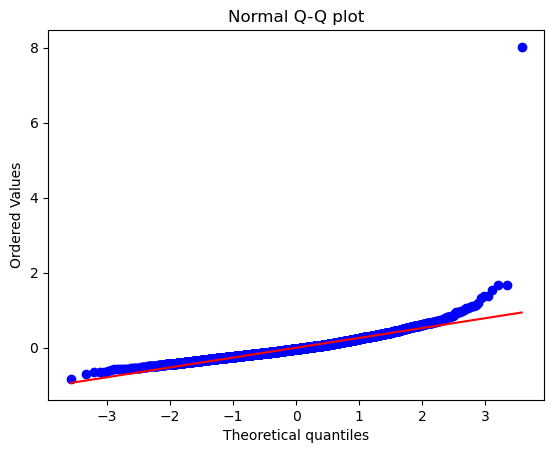

In [138]:
print("Train")
### H0: e_i~Normal vs H1: e_i !~ Normal
sw = shapiro(residuals_pearson_train)
print(f"Shapiro-Wilks estaditico: {sw[0]}, p_value={sw[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ks = kstest(residuals_pearson_train, 'norm')
print(f"Kolmogorov-Smirnov estaditico: {ks[0]}, p_value={ks[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ad = anderson(residuals_pearson_train, dist='norm')
print(f"Anderson-Darling estaditico: {ad[0]}, valorCritico={ad[1][2]}")

print("\nTest")
### H0: e_i~Normal vs H1: e_i !~ Normal
sw = shapiro(residuals_pearson_test)
print(f"Shapiro-Wilks estaditico: {sw[0]}, p_value={sw[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ks = kstest(residuals_pearson_test, 'norm')
print(f"Kolmogorov-Smirnov estaditico: {ks[0]}, p_value={ks[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ad = anderson(residuals_pearson_test, dist='norm')
print(f"Anderson-Darling estaditico: {ad[0]}, valorCritico={ad[1][2]}")

# Normalidad en los errores para Pearson
stats.probplot(residuals_pearson_train, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

**Train**


*   Shapiro: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
*   Kolmogorov: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
*   Anderson: A un nivel de significancia del 0.05 como el estadistico de prueba sobrepasa el valor crítico y cae en region de Rechazo, existe evidencia suficiente para rechazar Normalidad

Como el test de shapiro Wilks, Kolmogorov Smirnov y Anderson Darling rechazaron normalidad podemos suponer que no hay normalidad en los residuales.

**No cumple**

**Test**


*   Shapiro: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
*   Kolmogorov: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
*   Anderson: A un nivel de significancia del 0.05 como el estadistico de prueba sobrepasa el valor crítico y cae en region de Rechazo, existe evidencia suficiente para rechazar Normalidad

Como el test de shapiro Wilks, Kolmogorov Smirnov y Anderson Darling rechazaron normalidad podemos suponer que no hay normalidad en los residuales.

**No cumple**

#### Kendall

Train
Shapiro-Wilks estaditico: 0.7873447029652608, p_value=8.538441565624702e-58
Kolmogorov-Smirnov estaditico: 0.2860339027902923, p_value=3.2172473040861904e-284
Anderson-Darling estaditico: 41.55000258253676, valorCritico=0.786
Test
Shapiro-Wilks estaditico: 0.9823205650104935, p_value=1.5967563982008587e-09
Kolmogorov-Smirnov estaditico: 0.27777639062273857, p_value=2.395312976217853e-67
Anderson-Darling estaditico: 4.557575497755124, valorCritico=0.784


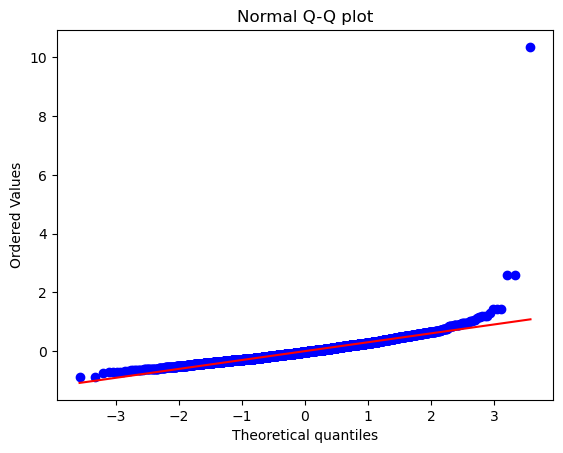

In [139]:
print("Train")
### H0: e_i~Normal vs H1: e_i !~ Normal
sw = shapiro(residuals_kendall_train)
print(f"Shapiro-Wilks estaditico: {sw[0]}, p_value={sw[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ks = kstest(residuals_kendall_train, 'norm')
print(f"Kolmogorov-Smirnov estaditico: {ks[0]}, p_value={ks[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ad = anderson(residuals_kendall_train, dist='norm')
print(f"Anderson-Darling estaditico: {ad[0]}, valorCritico={ad[1][2]}")

print("Test")
### H0: e_i~Normal vs H1: e_i !~ Normal
sw = shapiro(residuals_kendall_test)
print(f"Shapiro-Wilks estaditico: {sw[0]}, p_value={sw[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ks = kstest(residuals_kendall_test, 'norm')
print(f"Kolmogorov-Smirnov estaditico: {ks[0]}, p_value={ks[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ad = anderson(residuals_kendall_test, dist='norm')
print(f"Anderson-Darling estaditico: {ad[0]}, valorCritico={ad[1][2]}")

# Normalidad en los errores para Kendall
stats.probplot(residuals_kendall_train, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

Train

Shapiro: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
Kolmogorov: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
Anderson: A un nivel de significancia del 0.05 como el estadistico de prueba sobrepasa el valor crítico y cae en region de Rechazo, existe evidencia suficiente para rechazar Normalidad
Como el test de shapiro Wilks, Kolmogorov Smirnov y Anderson Darling rechazaron normalidad podemos suponer que no hay normalidad en los residuales.

No cumple

Test

Shapiro: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
Kolmogorov: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad.
Anderson: A un nivel de significancia del 0.05 como el estadistico de prueba sobrepasa el valor crítico y cae en region de Rechazo, existe evidencia suficiente para rechazar Normalidad
Como el test de shapiro Wilks, Kolmogorov Smirnov y Anderson Darling rechazaron normalidad podemos suponer que no hay normalidad en los residuales.

No cumple

#### Spearman

Train
Shapiro-Wilks estaditico: 0.793304543240028, p_value=2.791792577304217e-57
Kolmogorov-Smirnov estaditico: 0.29943692234510216, p_value=5.0901507307e-312
Anderson-Darling estaditico: 45.721702208462375, valorCritico=0.786
Test
Shapiro-Wilks estaditico: 0.9878932480248609, p_value=3.10716582874707e-07
Kolmogorov-Smirnov estaditico: 0.2913621823178541, p_value=3.4779618485495762e-74
Anderson-Darling estaditico: 4.015337562992727, valorCritico=0.784


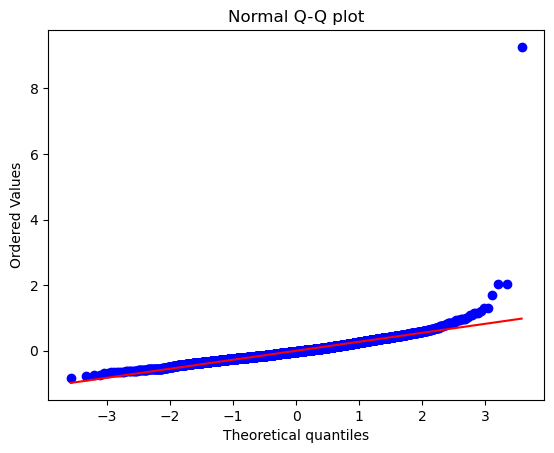

In [140]:
print("Train")
### H0: e_i~Normal vs H1: e_i !~ Normal
sw = shapiro(residuals_spearman_train)
print(f"Shapiro-Wilks estaditico: {sw[0]}, p_value={sw[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ks = kstest(residuals_spearman_train, 'norm')
print(f"Kolmogorov-Smirnov estaditico: {ks[0]}, p_value={ks[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ad = anderson(residuals_spearman_train, dist='norm')
print(f"Anderson-Darling estaditico: {ad[0]}, valorCritico={ad[1][2]}")

print("Test")
### H0: e_i~Normal vs H1: e_i !~ Normal
sw = shapiro(residuals_spearman_test)
print(f"Shapiro-Wilks estaditico: {sw[0]}, p_value={sw[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ks = kstest(residuals_spearman_test, 'norm')
print(f"Kolmogorov-Smirnov estaditico: {ks[0]}, p_value={ks[1]}")

### H0: e_i~Normal vs H1: e_i !~ Normal
ad = anderson(residuals_spearman_test, dist='norm')
print(f"Anderson-Darling estaditico: {ad[0]}, valorCritico={ad[1][2]}")

# Normalidad en los errores para Spearman
stats.probplot(residuals_spearman_train, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()


**Train**

Shapiro: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad. Kolmogorov: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad. Anderson: A un nivel de significancia del 0.05 como el estadistico de prueba sobrepasa el valor crítico y cae en region de Rechazo, existe evidencia suficiente para rechazar Normalidad Como el test de shapiro Wilks, Kolmogorov Smirnov y Anderson Darling rechazaron normalidad podemos suponer que no hay normalidad en los residuales.

**No cumple**

**Test**

Shapiro: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad. Kolmogorov: A un nivel De significancia del 0.05 como el p-value es menor al alpha, existe evidencia suficiente para rechazar Normalidad. Anderson: A un nivel de significancia del 0.05 como el estadistico de prueba sobrepasa el valor crítico y cae en region de Rechazo, existe evidencia suficiente para rechazar Normalidad Como el test de shapiro Wilks, Kolmogorov Smirnov y Anderson Darling rechazaron normalidad podemos suponer que no hay normalidad en los residuales.

**No cumple**

### Independencia en los errores

#### Pearson

In [141]:
print("Train")
## H0: Corr(e_i, e_i-1)=0 vs H1: corr(e_i, e_i-1) != 0
print(durbin_watson(residuals_pearson_train))

print("Test")
## H0: Corr(e_i, e_i-1)=0 vs H1: corr(e_i, e_i-1) != 0
print(durbin_watson(residuals_pearson_test))

Train
1.9875793170149374
Test
1.9962667467560082


Como el estadistico DW es menor a 2.5 y mayor a 1.5 **NO** existe suficiente evidencia muestral para rechazar la hopotesis nula en entrenamiento y prueba.

**Cumplen**

#### Kendall

In [142]:
print("Train")
## H0: Corr(e_i, e_i-1)=0 vs H1: corr(e_i, e_i-1) != 0
print(durbin_watson(residuals_kendall_train))

print("Test")
## H0: Corr(e_i, e_i-1)=0 vs H1: corr(e_i, e_i-1) != 0
print(durbin_watson(residuals_kendall_test))

Train
1.9629737465212702
Test
2.0222738855220355


Como el estadistico DW es menor a 2.5 y mayor a 1.5 **NO** existe suficiente evidencia muestral para rechazar la hopotesis nula en entrenamiento y prueba

**Cumplen**

#### Spearman

In [143]:
print("Train")
## H0: Corr(e_i, e_i-1)=0 vs H1: corr(e_i, e_i-1) != 0
print(durbin_watson(residuals_spearman_train))

print("Test")
## H0: Corr(e_i, e_i-1)=0 vs H1: corr(e_i, e_i-1) != 0
print(durbin_watson(residuals_spearman_test))

Train
1.9760641531806393
Test
2.037480948464372


Como el estadistico DW es menor a 2.5 y mayor a 1.5 **NO** existe suficiente evidencia muestral para rechazar la hopotesis nula en entrenamiento y prueba

**Cumplen**

###  Homocedasticidad en los errores

#### Pearson

In [144]:
print("Train")
## H0: Homocedasticidad vs H1: Heterocedasticidad
LM, PLM, f_test, p_value = het_breuschpagan(residuals_pearson_train, sm.add_constant(df_scaled.iloc[:,1:]), robust = False)
print(p_value)

print("Test")
## H0: Homocedasticidad vs H1: Heterocedasticidad
LM, PLM, f_test, p_value = het_breuschpagan(residuals_pearson_test, sm.add_constant(X_test), robust = False)
print(p_value)

Train
1.6079533450372934e-44
Test
1.3158629383748106e-07


Con un nivel de significancia del 0.05 como el p-valor asociadio al test BP es menor al alpha. Existe suficiente evidencia muestral para rechazar la hipotesis nula.

**No Cumple**

#### Kendall

In [145]:
print("Train")
## H0: Homocedasticidad vs H1: Heterocedasticidad
LM, PLM, f_test, p_value = het_breuschpagan(residuals_kendall_train, sm.add_constant(df_scaled.iloc[:,1:]), robust = False)
print(p_value)

print("Test")
## H0: Homocedasticidad vs H1: Heterocedasticidad
LM, PLM, f_test, p_value = het_breuschpagan(residuals_kendall_test, sm.add_constant(X_test), robust = False)
print(p_value)

Train
2.5685495536102702e-48
Test
0.005063412541839972


Con un nivel de significancia del 0.05 como el p-valor asociadio al test BP es menor al alpha. Existe suficiente evidencia muestral para rechazar la hipotesis nula.

**No Cumple**

#### Spearman

In [146]:
print("Train")
## H0: Homocedasticidad vs H1: Heterocedasticidad
LM, PLM, f_test, p_value = het_breuschpagan(residuals_spearman_train, sm.add_constant(df_scaled.iloc[:,1:]), robust = False)
print(p_value)

print("Test")
## H0: Homocedasticidad vs H1: Heterocedasticidad
LM, PLM, f_test, p_value = het_breuschpagan(residuals_spearman_test, sm.add_constant(X_test), robust = False)
print(p_value)

Train
2.7344368908622898e-45
Test
8.475640489522233e-16


Con un nivel de significancia del 0.05 como el p-valor asociadio al test BP es menor al alpha. Existe suficiente evidencia muestral para rechazar la hipotesis nula.

**No Cumple**

### Conclusiones en los supuestos

1. Esperanza de los errores es cero: Los 3 modelos cumplen en entrenamiento pero no en prueba
2. Normalidad de los errores: Ninguno cumple
3. Independencia de los errores: Los 3 cumplen
4. Homoceasticidad en los errores: Ninguno cumple

## Diagrama de dispersión del conjunto de datos

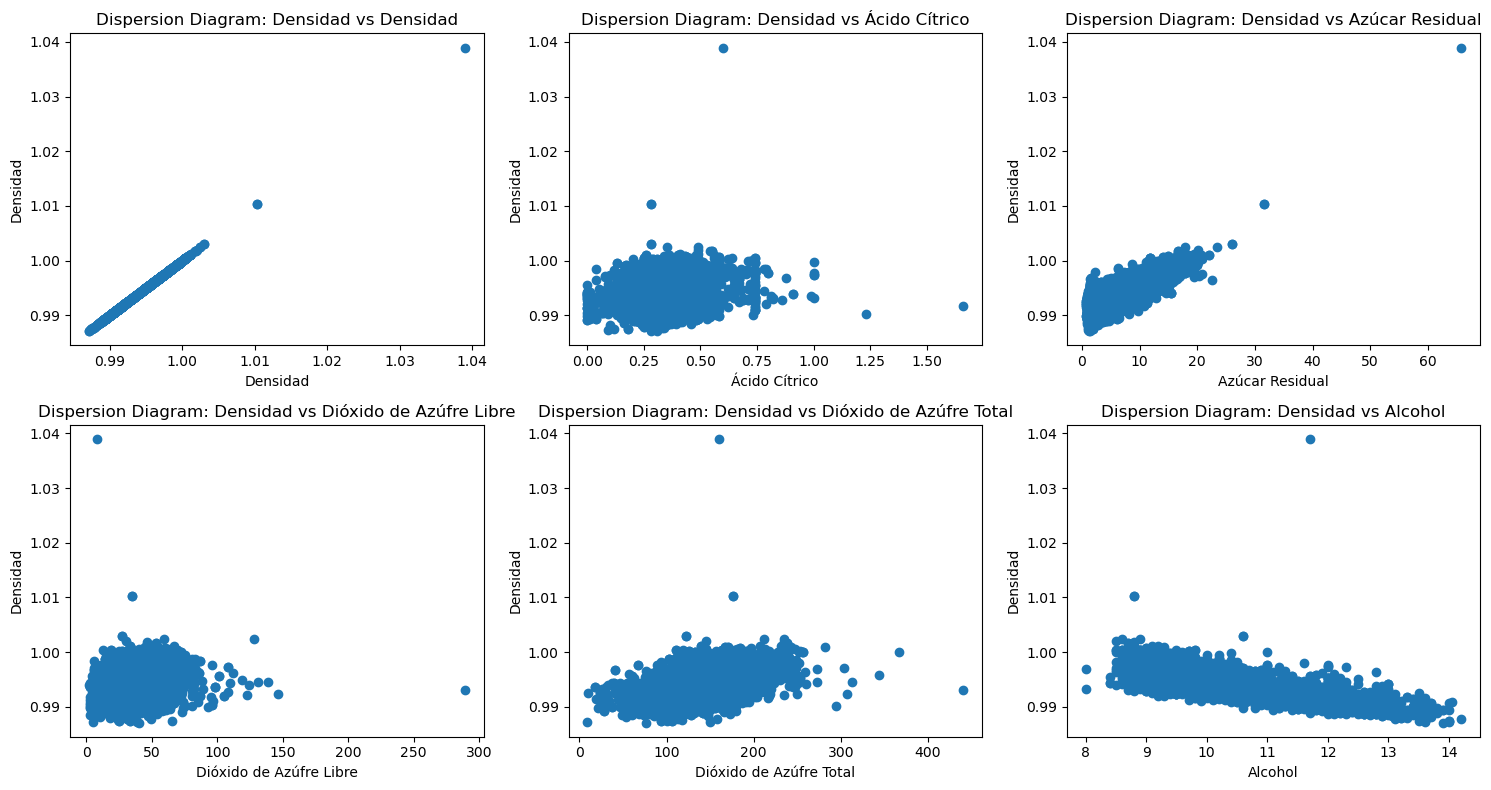

In [147]:
# prompt: create dispersion diagram of df_wine vs the column "densidad"

# Create a scatter plot for each column against 'Densidad'
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = ax.flatten()

# Iterate over columns in the DataFrame
for i, column in enumerate(df_wine.columns):
      # Create the scatter plot on the corresponding axes
      axes[i].scatter(df_wine[column], df_wine['Densidad'])

      # Set titles and labels
      axes[i].set_title(f'Dispersion Diagram: Densidad vs {column}')
      axes[i].set_ylabel('Densidad')
      axes[i].set_xlabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### ¿Se evidencian comportamientos totalmente lineales?

No se evidencia comportamientos totalmente lineales. El **Dioxido de Azufre Libre** y el **Ácido cítrico** no demuestra linealidad. Se sugiere hacer una transformación sobre dichas variables.

c:\Users\Andres Borrero\.conda\envs\Dev\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Ácido Cítrico')

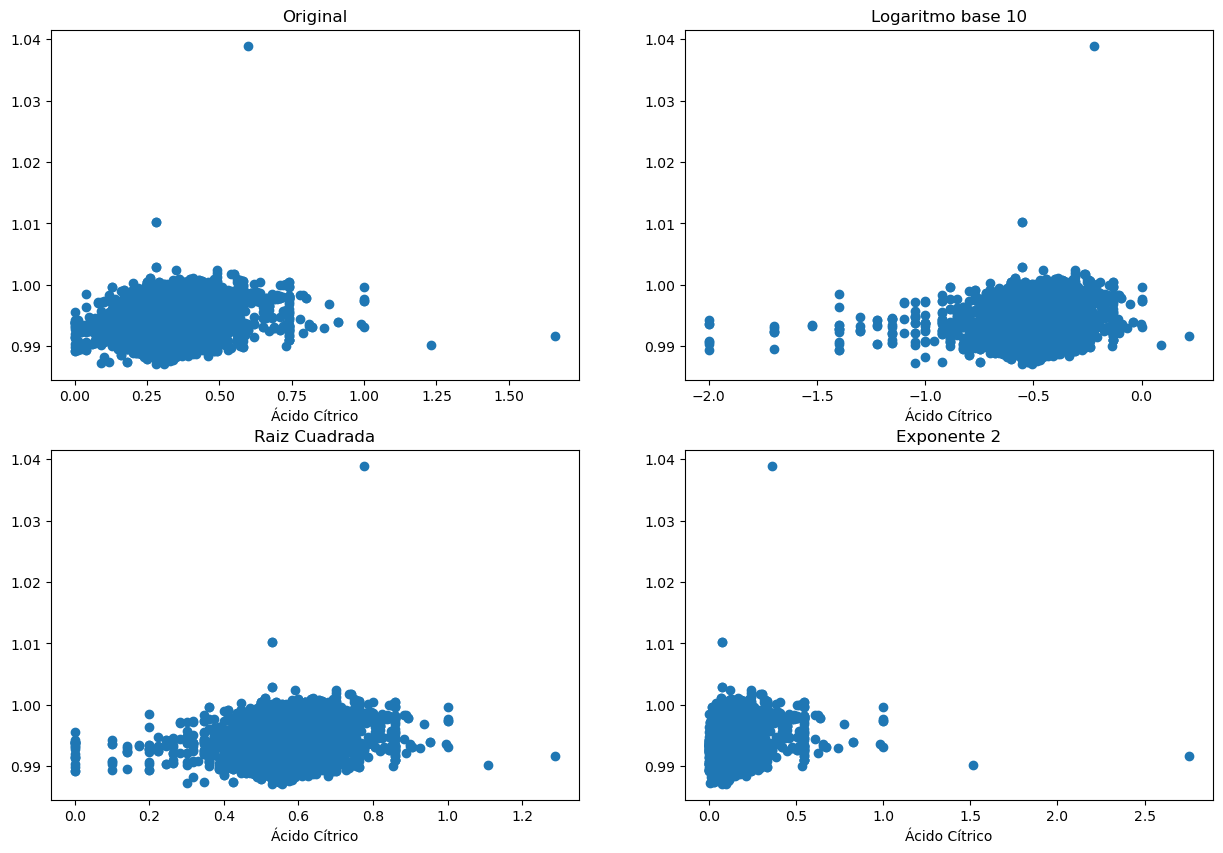

In [148]:
# Transformación de la variable 'Ácido Cítrico'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax = ax.flatten()

# Plot Acido Citrico vs Densidad antes de la transformación
ax[0].scatter(df_wine['Ácido Cítrico'], df_wine['Densidad'])
ax[0].set_title('Original')
ax[0].set_xlabel('Ácido Cítrico')


df_wine_transformed = df_wine.copy()
# # df_wine_transformed['Dióxido de Azúfre Libre'] =  (df_wine_transformed['Dióxido de Azúfre Libre']) ** (1/8)
# df_wine_transformed['Ácido Cítrico'] =  (df_wine_transformed['Ácido Cítrico'])**(1.5)
# Transformar aplicando logaritmo base 10 a la variable 'Ácido Cítrico'
df_wine_transformed['Ácido Cítrico'] = np.log10(df_wine['Ácido Cítrico'])

# Plot Acido Citrico vs Densidad después de la transformación
ax[1].scatter(df_wine_transformed['Ácido Cítrico'], df_wine_transformed['Densidad'])
ax[1].set_title('Logaritmo base 10')
ax[1].set_xlabel('Ácido Cítrico')


# Transformar aplicando raiz cuadrada a la variable 'Ácido Cítrico'
df_wine_transformed['Ácido Cítrico'] = np.sqrt(df_wine['Ácido Cítrico'])

# Plot Acido Citrico vs Densidad después de la transformación
ax[2].scatter(df_wine_transformed['Ácido Cítrico'], df_wine_transformed['Densidad'])
ax[2].set_title('Raiz Cuadrada')
ax[2].set_xlabel('Ácido Cítrico')

# Transformar aplicando exponente 2 a la variable 'Ácido Cítrico'
df_wine_transformed['Ácido Cítrico'] = df_wine['Ácido Cítrico'] ** 2

# Plot Acido Citrico vs Densidad después de la transformación
ax[3].scatter(df_wine_transformed['Ácido Cítrico'], df_wine_transformed['Densidad'])
ax[3].set_title('Exponente 2')
ax[3].set_xlabel('Ácido Cítrico')


A partir de las gráficas se visualiza una leve tendencia lineal más clara en la transformación de raíz cuadrada. Se escoge esta transformación para aplicar el modelo de Pearson. Se escoge Pearson como Baseline al ser el modelo que actualmente presenta la mejor predicción.

In [149]:
# Validación de la transformación Raiz cuadrada con el modelo de Pearson a la variable 'Ácido Cítrico'
df_wine_transformed = df_wine.copy()
df_wine_transformed['Ácido Cítrico'] = np.sqrt(df_wine['Ácido Cítrico'])

df_train, df_test = train_test_split(df_wine_transformed, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(df_train)
df_scaled = pd.DataFrame(scaler.transform(df_train))

Sigma = df_scaled.corr(method = "pearson").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_pearson = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_pearson = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Pearson')
print(f'B_0: {B_0_pearson}')
print('B:', B_pearson)
print('\nEcuación de la recta:')
print(f'y = {B_0_pearson.round(2)} + {B_pearson[0].round(2)} Ácido Cítrico + {B_pearson[1].round(2)} Azúcar Residual {B_pearson[2].round(2)} Dióxido de Azúfre Libre + {B_pearson[3].round(2)} Dióxido de Azúfre Total {B_pearson[4].round(2)} Alcohol')



Coeficientes de Pearson
B_0: 7.173315947891088e-15
B: [ 0.05189969  0.60399507 -0.08332851  0.11980914 -0.46534588]

Ecuación de la recta:
y = 0.0 + 0.05 Ácido Cítrico + 0.6 Azúcar Residual -0.08 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.47 Alcohol


In [150]:
# Calculo del RMSE con Pearson
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)
y_test = df_test_scaled["Densidad"].values
X_test = df_test_scaled.drop("Densidad", axis = 1).values

# Predicción con Pearson
y_pearson = B_0_pearson + np.dot(X_test, B_pearson)

# RMSE con Pearson
# Imprimir valor previo del RMSE
rmse_pearson_org = rmse_pearson
print('RMSE Pearson Antes:', rmse_pearson_org)
rmse_pearson = root_mean_squared_error(y_test,y_pearson)
print('RMSE Pearson Despues:', rmse_pearson)
# Imprimir cambio porcentual en el rmse
print(f'Cambio porcentual: {((rmse_pearson_org - rmse_pearson) / rmse_pearson_org) * 100:.2f}%')

RMSE Pearson Antes: 0.25411925669466573
RMSE Pearson Despues: 0.253453957885699
Cambio porcentual: 0.26%


La transformación genera un aumento en el RMSE de Pearson por un valor de 0.26% por lo que se considera que el error aumenta. Se procede a intentar una transformación logarítmica.

In [151]:
# Validación de la transformación Logaritmo base 10 con el modelo de Pearson a la variable 'Ácido Cítrico'
df_wine_transformed = df_wine.copy()

# Eliminar valores donde la variable 'Ácido Cítrico' sea 0
df_wine_transformed = df_wine_transformed[df_wine_transformed['Ácido Cítrico'] != 0]
df_wine_transformed['Ácido Cítrico'] = np.log10(df_wine['Ácido Cítrico'])

df_train, df_test = train_test_split(df_wine_transformed, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(df_train)
df_scaled = pd.DataFrame(scaler.transform(df_train))

Sigma = df_scaled.corr(method = "pearson").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_pearson = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_pearson = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Pearson')
print(f'B_0: {B_0_pearson}')
print('B:', B_pearson)
print('\nEcuación de la recta:')
print(f'y = {B_0_pearson.round(2)} + {B_pearson[0].round(2)} Ácido Cítrico + {B_pearson[1].round(2)} Azúcar Residual {B_pearson[2].round(2)} Dióxido de Azúfre Libre + {B_pearson[3].round(2)} Dióxido de Azúfre Total {B_pearson[4].round(2)} Alcohol')


Coeficientes de Pearson
B_0: 3.619420849930328e-14
B: [ 0.04994889  0.60199558 -0.08523917  0.12254613 -0.46943186]

Ecuación de la recta:
y = 0.0 + 0.05 Ácido Cítrico + 0.6 Azúcar Residual -0.09 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.47 Alcohol


c:\Users\Andres Borrero\.conda\envs\Dev\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'Dióxido de Azúfre Libre')

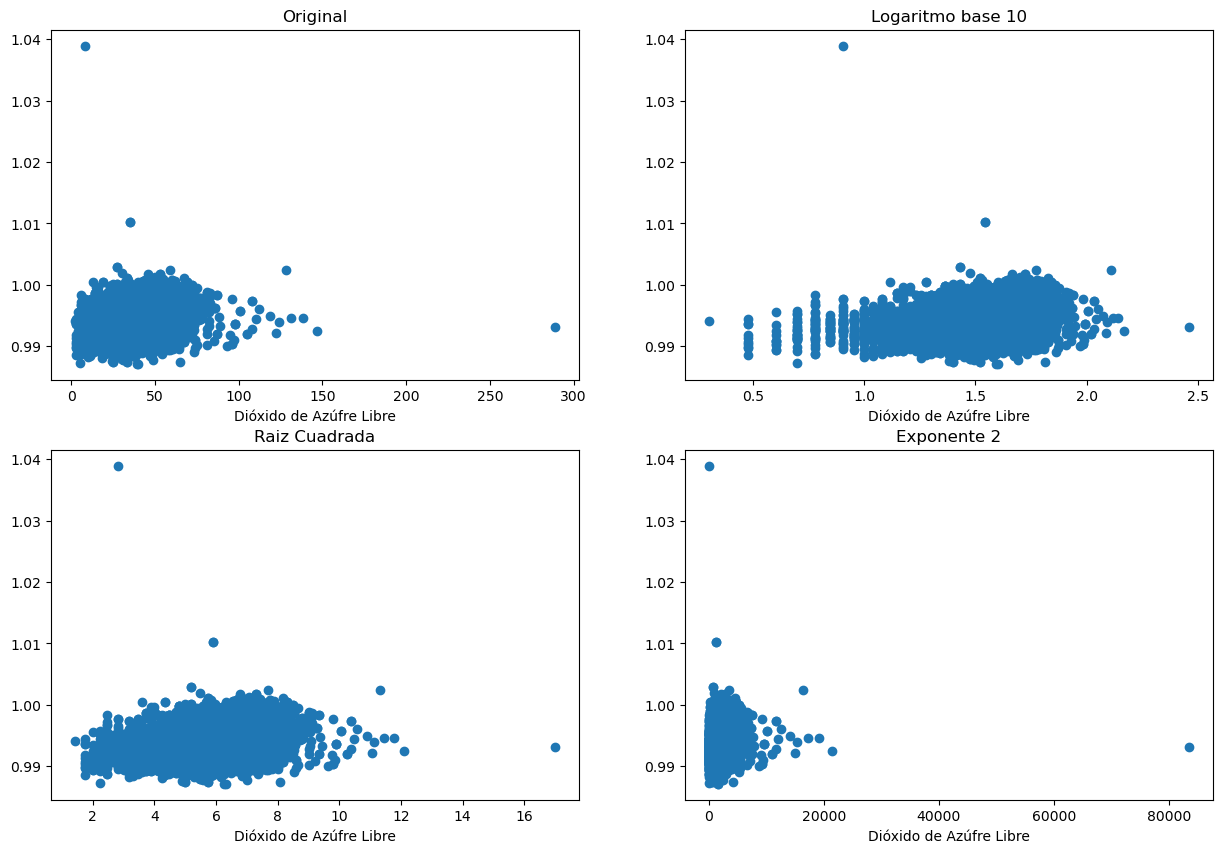

In [152]:
# Transformación de la variable 'Dioxido de Azufre Libre'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax = ax.flatten()

# Plot Dióxido de Azúfre Libre vs Densidad antes de la transformación
ax[0].scatter(df_wine['Dióxido de Azúfre Libre'], df_wine['Densidad'])
ax[0].set_title('Original')
ax[0].set_xlabel('Dióxido de Azúfre Libre')


df_wine_transformed = df_wine.copy()
# Transformar aplicando logaritmo base 10 a la variable 'Dióxido de Azúfre Libre'
df_wine_transformed['Dióxido de Azúfre Libre'] = np.log10(df_wine['Dióxido de Azúfre Libre'])

# Plot Dióxido de Azúfre Libre vs Densidad después de la transformación
ax[1].scatter(df_wine_transformed['Dióxido de Azúfre Libre'], df_wine_transformed['Densidad'])
ax[1].set_title('Logaritmo base 10')
ax[1].set_xlabel('Dióxido de Azúfre Libre')


# Transformar aplicando raiz cuadrada a la variable 'Dióxido de Azúfre Libre'
df_wine_transformed['Dióxido de Azúfre Libre'] = np.sqrt(df_wine['Dióxido de Azúfre Libre'])

# Plot Dióxido de Azúfre Libre vs Densidad después de la transformación
ax[2].scatter(df_wine_transformed['Dióxido de Azúfre Libre'], df_wine_transformed['Densidad'])
ax[2].set_title('Raiz Cuadrada')
ax[2].set_xlabel('Dióxido de Azúfre Libre')

# Transformar aplicando exponente 2 a la variable 'Dióxido de Azúfre Libre'
df_wine_transformed['Dióxido de Azúfre Libre'] = df_wine['Dióxido de Azúfre Libre'] ** 2

# Plot Dióxido de Azúfre Libre vs Densidad después de la transformación
ax[3].scatter(df_wine_transformed['Dióxido de Azúfre Libre'], df_wine_transformed['Densidad'])
ax[3].set_title('Exponente 2')
ax[3].set_xlabel('Dióxido de Azúfre Libre')



A partir de las gráficas se visualiza una leve tendencia lineal más clara en la transformación Logarítmica base 10 y en la Raiz cuadrada. Se decide validar el modelo de pearson para ambas transformaciones y comparar los RMSE.

In [153]:
# Validación de la transformación Logaritmo base 10 con el modelo de Pearson
df_wine_transformed = df_wine.copy()
df_wine_transformed['Dióxido de Azúfre Libre'] = np.log10(df_wine['Dióxido de Azúfre Libre'])

df_train, df_test = train_test_split(df_wine_transformed, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(df_train)
df_scaled = pd.DataFrame(scaler.transform(df_train))

Sigma = df_scaled.corr(method = "pearson").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_pearson = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_pearson = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Pearson')
print(f'B_0: {B_0_pearson}')
print('B:', B_pearson)
print('\nEcuación de la recta:')
print(f'y = {B_0_pearson.round(2)} + {B_pearson[0].round(2)} Ácido Cítrico + {B_pearson[1].round(2)} Azúcar Residual {B_pearson[2].round(2)} Dióxido de Azúfre Libre + {B_pearson[3].round(2)} Dióxido de Azúfre Total {B_pearson[4].round(2)} Alcohol')



Coeficientes de Pearson
B_0: 7.175175359655728e-15
B: [ 0.05029105  0.60552485 -0.08020032  0.11792277 -0.46128878]

Ecuación de la recta:
y = 0.0 + 0.05 Ácido Cítrico + 0.61 Azúcar Residual -0.08 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.46 Alcohol


In [154]:
# Calculo del RMSE con Pearson
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)
y_test = df_test_scaled["Densidad"].values
X_test = df_test_scaled.drop("Densidad", axis = 1).values

# Predicción con Pearson
y_pearson = B_0_pearson + np.dot(X_test, B_pearson)

# RMSE con Pearson
# Imprimir valor previo del RMSE
print('RMSE Pearson Antes:', rmse_pearson_org)
rmse_pearson = root_mean_squared_error(y_test,y_pearson)
print('RMSE Pearson Despues:', rmse_pearson)
# Imprimir cambio porcentual en el rmse
print(f'Cambio porcentual: {((rmse_pearson_org - rmse_pearson) / rmse_pearson_org) * 100:.2f}%')


RMSE Pearson Antes: 0.25411925669466573
RMSE Pearson Despues: 0.25449798721476385
Cambio porcentual: -0.15%


Con un cambio negativo en el rmse del -0.15% se decide no realizar una transformación por Logarítmo base 10 de la variable Dióxido de Azufre Libre.

In [155]:
# Validación de la transformación Raiz cuadrada con el modelo de Pearson para la variable 'Dióxido de Azúfre Libre'
df_wine_transformed = df_wine.copy()
df_wine_transformed['Dióxido de Azúfre Libre'] = np.sqrt(df_wine['Dióxido de Azúfre Libre'])

df_train, df_test = train_test_split(df_wine_transformed, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(df_train)
df_scaled = pd.DataFrame(scaler.transform(df_train))

Sigma = df_scaled.corr(method = "pearson").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_pearson = np.linalg.inv(SigmaXX) @ SigmaXy

B_0_pearson = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Pearson')
print(f'B_0: {B_0_pearson}')
print('B:', B_pearson)
print('\nEcuación de la recta:')
print(f'y = {B_0_pearson.round(2)} + {B_pearson[0].round(2)} Ácido Cítrico + {B_pearson[1].round(2)} Azúcar Residual {B_pearson[2].round(2)} Dióxido de Azúfre Libre + {B_pearson[3].round(2)} Dióxido de Azúfre Total {B_pearson[4].round(2)} Alcohol')



Coeficientes de Pearson
B_0: 7.175759591141236e-15
B: [ 0.05117163  0.605867   -0.08613963  0.12257712 -0.46225354]

Ecuación de la recta:
y = 0.0 + 0.05 Ácido Cítrico + 0.61 Azúcar Residual -0.09 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.46 Alcohol


In [156]:
# Calculo del RMSE con Pearson
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)
y_test = df_test_scaled["Densidad"].values
X_test = df_test_scaled.drop("Densidad", axis = 1).values

# Predicción con Pearson
y_pearson = B_0_pearson + np.dot(X_test, B_pearson)

# RMSE con Pearson
# Imprimir valor previo del RMSE
print('RMSE Pearson Antes:', rmse_pearson_org)
rmse_pearson = root_mean_squared_error(y_test,y_pearson)
print('RMSE Pearson Despues:', rmse_pearson)
# Imprimir cambio porcentual en el rmse
print(f'Cambio porcentual: {((rmse_pearson_org - rmse_pearson) / rmse_pearson_org) * 100:.2f}%')


RMSE Pearson Antes: 0.25411925669466573
RMSE Pearson Despues: 0.2534435887554909
Cambio porcentual: 0.27%


Se encuentra que la transformación del Dióxido de Azufre Libre con Raiz Cuadrada mejora el RMSE de Pearson en un 0.27%. Se procede a realizar el modelo de Pearson aplicando las transformaciones a las 2 variables Dioxido de Azufre Libre y Ácido Cítrico

In [157]:
# Se agrega la transformación de raiz cuadrada a la variable 'Ácido Cítrico' y 'Dióxido de Azúfre Libre'
df_wine_transformed = df_wine.copy()
df_wine_transformed['Ácido Cítrico'] = np.sqrt(df_wine['Ácido Cítrico'])
df_wine_transformed['Dióxido de Azúfre Libre'] = np.sqrt(df_wine['Dióxido de Azúfre Libre'])

df_train, df_test = train_test_split(df_wine_transformed, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(df_train)
df_scaled = pd.DataFrame(scaler.transform(df_train))

Sigma = df_scaled.corr(method = "pearson").values
SigmaXX = Sigma[1:, 1:]
SigmaXy = Sigma[1:, 0]
B_pearson = np.linalg.inv(SigmaXX) @ SigmaXy
B_0_pearson = df_scaled.mean(axis = 0)[0] - df_scaled.mean(axis = 0)[1:] @ B_pearson
print('Coeficientes de Pearson')
print(f'B_0: {B_0_pearson}')
print('B:', B_pearson)
print('\nEcuación de la recta:')
print(f'y = {B_0_pearson.round(2)} + {B_pearson[0].round(2)} Ácido Cítrico + {B_pearson[1].round(2)} Azúcar Residual {B_pearson[2].round(2)} Dióxido de Azúfre Libre + {B_pearson[3].round(2)} Dióxido de Azúfre Total {B_pearson[4].round(2)} Alcohol')


Coeficientes de Pearson
B_0: 7.174326067986322e-15
B: [ 0.05167247  0.60524157 -0.08621628  0.12234158 -0.46358378]

Ecuación de la recta:
y = 0.0 + 0.05 Ácido Cítrico + 0.61 Azúcar Residual -0.09 Dióxido de Azúfre Libre + 0.12 Dióxido de Azúfre Total -0.46 Alcohol


In [158]:
# Calculo del RMSE con Pearson
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)
y_test = df_test_scaled["Densidad"].values
X_test = df_test_scaled.drop("Densidad", axis = 1).values

# Predicción con Pearson
y_pearson = B_0_pearson + np.dot(X_test, B_pearson)

# RMSE con Pearson
# Imprimir valor previo del RMSE
print('RMSE Pearson Antes:', rmse_pearson_org)
rmse_pearson = root_mean_squared_error(y_test,y_pearson)
print('RMSE Pearson Despues:', rmse_pearson)
# Imprimir cambio porcentual en el rmse
print(f'Cambio porcentual: {((rmse_pearson_org - rmse_pearson) / rmse_pearson_org) * 100:.2f}%')


RMSE Pearson Antes: 0.25411925669466573
RMSE Pearson Despues: 0.2527838498207521
Cambio porcentual: 0.53%


La transformación por raíz cuadrada de las dos variables, Ácido Cítrico y Dóxido de Azufre Libre generan una mejora po